---
layout: post
title: "시계열 데이터를 다뤄보자"
author: "Chanjun Kim"
categories: Data분석
tags: [Data, TimeSeries, ARIMA, LSTM, BOOSTING, REGRESSION, 시계열데이터, 시계열분석]
image: API_img.png
---

## **학습목적**
시계열 데이터를 다루는 법과 시계열 예측을 하기 위한 여러가지 모델을 사용해보고 특성을 이해한다.<br>
이를 위해서 데이콘에서 진행 중인 대회인 전력사용량 예측 AI 경진대회의 데이터를 사용하고, 베이스라인 코드를 따라하고 또 나만의 코드로 만들어 결과를 제출하여 순위도 확인해볼 것이다.

### **시계열 데이터란?**
일정 시간 간격으로 배치된 데이터<br>
### **시계열 분석의 목표**
이런 시계열이 어떤 법칙에서 생성되는지 기본적인 질문을 이해하는 것<br> 
### **시계열 예측**
주어진 시계열을 보고 수학적인 모델을 만들어서 미래에 일어날 것들을 예측하는 것 _(X가 시계열 Y가 예측값)_<br>
일반적으로 이런 방법들은 금융시장에서의 주가 예측 등에서 많이 쓰인다.
> 출처 : https://ko.wikipedia.org/wiki/%EC%8B%9C%EA%B3%84%EC%97%B4

In [86]:
import os
import sys
import warnings

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import seaborn

import scipy
import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [45]:
%matplotlib inline
warnings.filterwarnings("ignore")

In [46]:
mpl.rcParams['axes.unicode_minus'] = False
# fm._rebuild()
plt.rcParams["font.family"] = 'NanumMyeongjo'
plt.rcParams["figure.figsize"] = (10,10)

---

**관련 단어 :**
- 계절성 : 특정 주기의 패턴을 가짐
- 주기성 : 특정 패턴을 가지나 일정한 주기를 갖지 않음
- 정상성 : 시계열 데이터가 추세나 계절성을 가지고 있지 않은 평균과 분산이 일정하여 시계열의 특징이 관측된 시간에 무관한 성질(주기성은 가질 수 있음) - <u>대부분의 시계열 데이터는 비정상성</u>
- 차분 : 평균이 일정하지 않은 시계열에 대하여 평균을 일정하게 만드는 작업
    - 일반 차분 : 전 시점의 자료의 차를 구하여 평균을 일정하게 만드는 방법
    - 계절 차분 : 계절성이 있는 자료에서 여러 시점의 차를 구하여 평균을 일정하게 만드는 방법
<br>
<br>
---

![Oops](https://otexts.com/fppkr/fpp_files/figure-html/stationary-1.png)

- 각 그림의 성질
    - 추세성 : a, c, e, f, i
    - 계절성 : d, h, i
    - 주기성 : g
    - 분산의 증가 : i
    - 정상성 : b, g


> 출처 : [https://otexts.com/fppkr/stationarity.html](https://otexts.com/fppkr/stationarity.html)

---

### **ARIMA(Autoregressvie integrated MovingAverage)**
**정의 :**
- 정상 시계열 데이터의 과거 관측값과 오차를 통하여 현재 시계열값을 예측하는 시계열 분석 기법 중 하나
<br>
<br>
- AR(Autoregression/자기상관) : 이전의 값이 이후의 값에 영향을 미치고 있는 상황
    - AR(1) 모델의 경우: yt = c + φ 1yt-1 + εt (−1 <ϕ1 <1)
    - AR(2) 모델의 경우: yt = c + φ 1yt-1 + φ 2yt-2 + εt
    <br>
    <br>
- I(Integrate/누적) : 차분을 이용
<br>
<br>
- MA(Moving Average/이동평균) : 랜덤 변수의 평균값이 지속적으로 증가하거나 감소하는 추세
    - 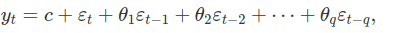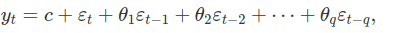
<br>
<br>
- ARIMA는 총 세개의 부분으로 이루어져 ARIMA(p, d, q)로 이루어진다.
    -  통상적으로 p + q < 2, p * q = 0 조건을 만족하는 모델을 사용한다고 한다.


In [82]:
y = 1
coff = 0.3
const = 0

0.0


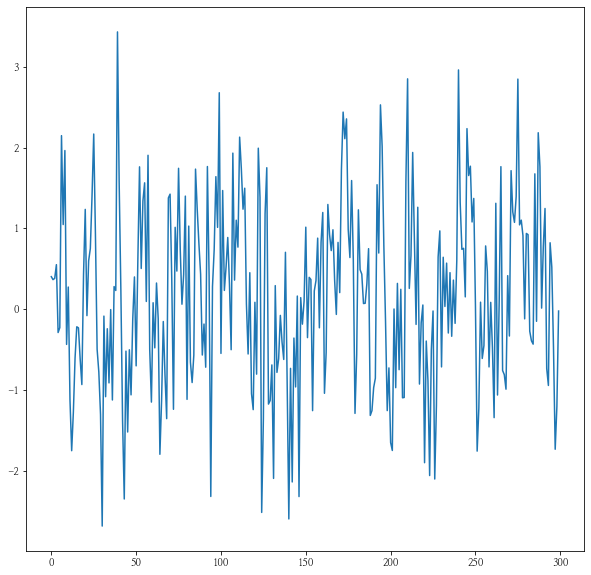

In [83]:
ar_process = []
for i in range(300):
    error = np.random.randn()
    y = const + y * coff + error
    ar_process.append(y)
print(const / (1 - coff))
plt.plot(ar_process)

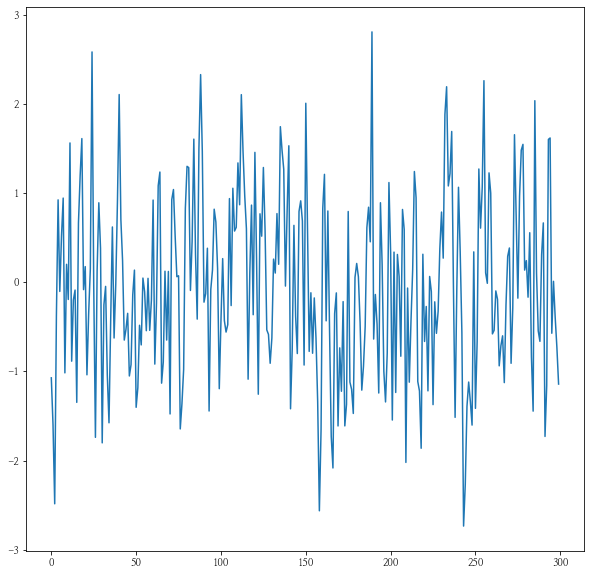

In [84]:
ma_process = []
error = np.random.randn()
for i in range(300):
    ex_error = error
    error = np.random.randn()
    y = const + coff * ex_error + error
    ma_process.append(y)
plt.plot(ma_process)

In [8]:
train = pd.read_csv("data/dacon/energy/train.csv", encoding = "cp949")
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [10]:
test = pd.read_csv("data/dacon/energy/test.csv", encoding = "cp949")
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [16]:
print(train.num.nunique())
print(test.num.nunique())
print(pd.concat([train.num.value_counts().sort_index(), test.num.value_counts()], axis = 1).head())

60
60
    num  num
1  2040  168
2  2040  168
3  2040  168
4  2040  168
5  2040  168


In [23]:
train.date_time = pd.to_datetime(train.date_time)
test.date_time = pd.to_datetime(test.date_time)

In [24]:
train.date_time.describe()

count                  122400
unique                   2040
top       2020-08-13 07:00:00
freq                       60
first     2020-06-01 00:00:00
last      2020-08-24 23:00:00
Name: date_time, dtype: object

In [25]:
test.date_time.describe()

count                   10080
unique                    168
top       2020-08-28 18:00:00
freq                       60
first     2020-08-25 00:00:00
last      2020-08-31 23:00:00
Name: date_time, dtype: object

In [26]:
print(2040 * 60)
print(168 * 60)

122400
10080


In [35]:
train.iloc[:,2:]

,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
122395,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [87]:
y_col = "전력사용량(kWh)"

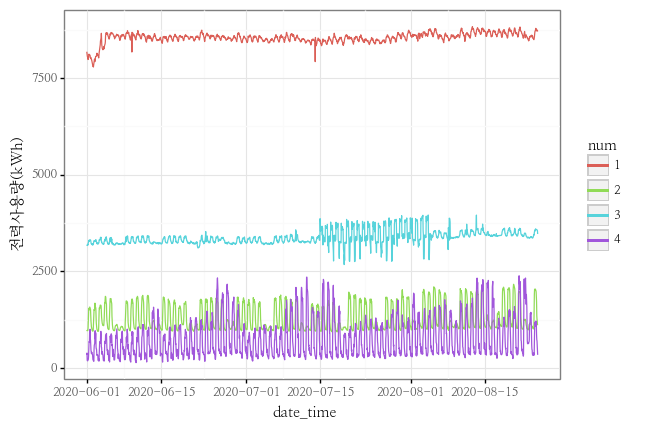

<ggplot: (110860174511)>

In [89]:
idxs = [1, 2, 3, 4]
(
    p9.ggplot() +
    p9.geom_line(data = train[train.num.isin(idxs)].assign(num = lambda x : x.num.astype(str)), mapping = p9.aes(x = "date_time", y = y_col, color = "num", group = "num")) +
    p9.theme_bw() +
    p9.theme(text = p9.element_text(family = "NanumMyeongjo"))
)

##### **AR, MA의 모수 추정**

- ACF(Autocorrelation function) : Lag에 따른 관측치들 사이의 관련성을 측정하는 함수
    - ![Oops](https://latex.codecogs.com/gif.latex?%5Crho_%7Bk%7D%3D%5Cfrac%7BCov%28y_%7Bt%7D%2C%20y_%7Bt+k%7D%29%7D%7BVar%28y_%7Bt%7D%29%7D)
<br>
<br>
- PACF(Partial autocorrelation function) : k 이외의 모든 다른 시점 관측치의 영향력을 배제하고 yt와 yt-k 두 관측치의 관련성을 측정하는 함수
    - ![Oops](https://latex.codecogs.com/gif.latex?%5Cphi_%7Bkk%7D%3Dcorr%28y_%7Bt%7D%2C%20y_%7Bt-k%7D%5Cmid%20y_%7Bt-1%7D%2C%20y_%7Bt-2%7D%2C%20...%2C%20y_%7Bt-k+1%7D%29)
<br>
<br>
- ##### **시계열 데이터가 AR의 특성을 띄는 경우, ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소한다.**
    - 사실 위에 정의를 정확히 이해하진 못하였으니 일단 이것만 기억하도록 한다.

> 출처 : [https://tjansry354.tistory.com/14](https://tjansry354.tistory.com/14) <br>
> 출처 : [https://kerpect.tistory.com/161](https://kerpect.tistory.com/161) <br>
> 출처 : [https://byeongkijeong.github.io/ARIMA-with-Python/](https://byeongkijeong.github.io/ARIMA-with-Python/)

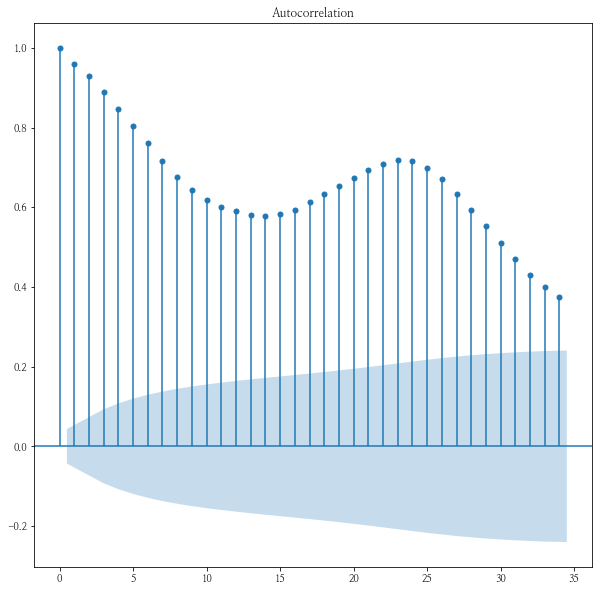

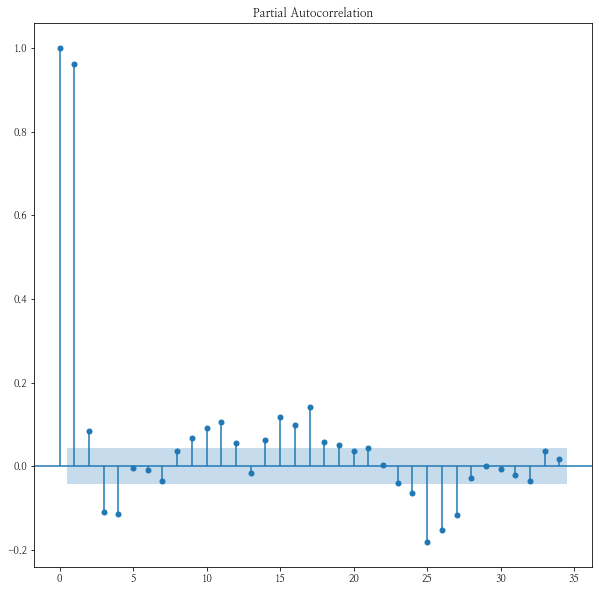

In [90]:
idx = 1
series = train[train.num == idx][y_col]
plot_acf(series)
plot_pacf(series)
plt.show()

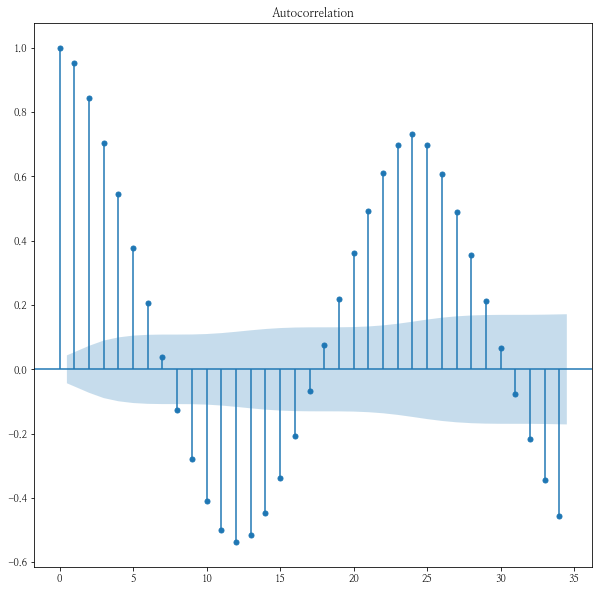

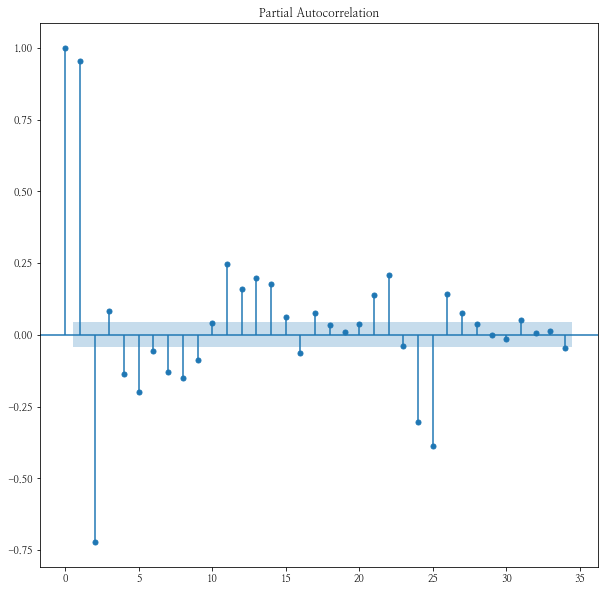

In [91]:
idx = 2
series = train[train.num == idx][y_col]
plot_acf(series)
plot_pacf(series)
plt.show()

<br>
<br>

---
<br>

참고 자료 : <br>
[https://dacon.io/competitions/official/235736/overview/description](https://dacon.io/competitions/official/235736/overview/description) <br>
[https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=sw4r&logNo=221023159390](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=sw4r&logNo=221023159390)
